# Multi Armed Bandit Playground

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import bernoulli
from scipy.stats import norm

# from tqdm.notebook import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm

## Slot Machine Simulator

Reward types:

* bernoulli
  - Binary reward (**0** or **1**) with probability *p*
* norm
  - Continuous reward drawn from a normal distribution defined by *μ* and *σ*


In [180]:
class SlotMachine(object):
    
    reward_type_list = ['bernoulli', 'norm']

    def __init__(self, lever_reward_list, reward_type = 'bernoulli', seed = None):
        
        if reward_type not in SlotMachine.reward_type_list:
            raise ValueError("Reward Type unknown")
        
        self.lever_reward_list = lever_reward_list
        self.reward_type = reward_type
        self.seed = seed
        np.random.seed(self.seed)

    def pull_lever(self, lever_idx):
        if self.reward_type == 'bernoulli':
            return bernoulli.rvs(self.lever_reward_list[lever_idx], size=1)[0]
        elif self.reward_type == 'norm':
            return norm.rvs(loc=self.lever_reward_list[lever_idx][0],scale=self.lever_reward_list[lever_idx][1],size=1)[0]       
    @property
    def n_levers(self):
        return len(self.lever_reward_list)

### Some simulations

In [6]:
def simulate_pull_lever(N, reward_list, reward_type):
    slot_machine = SlotMachine(reward_list, reward_type=reward_type)
    lever_reward_mean = {}

    fig = plt.figure(figsize=(10,5))
    for i, prob in enumerate(range(slot_machine.n_levers)):
        lever_reward_mean[prob] = np.mean([slot_machine.pull_lever(i) for _ in range(N)])

    p = sns.barplot(
        x=list(range(len(reward_list))),
        y=list(lever_reward_mean.values())
        )
    p.set(xticklabels=[f"Lever {i}" for i in list(range(len(reward_list)))])
    p.set(
        xlabel = 'Lever', 
        ylabel = 'Expected Reward',
        title=f"Expected reward for each lever. Reward type: '{reward_type}'")

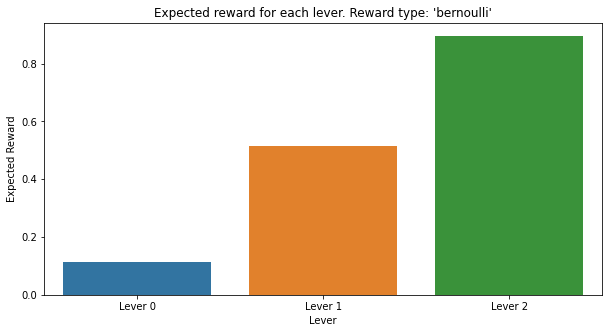

In [7]:
simulate_pull_lever(1000,[0.1, 0.5, 0.9], 'bernoulli')

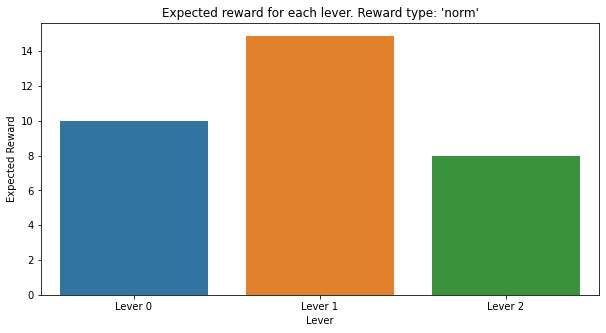

In [8]:
simulate_pull_lever(1000, [(10,1),(15,3),(8,2)], 'norm')

## Multi Armed Bandit agent

In [41]:
n_levers = 3
lever_sequence = np.array([ 0, 1,2, 1, 1, 1, 1,2, 1, 1,0,0, 1,2, 1,0, 1, 1])
reward_sequence = np.array([1,10,5,17,16,13,14,7,11,13,2,3,17,6,12,1,13,12])

In [47]:
lever_reward = {i:[] for i in range(n_levers)}
buffer_reward = {i:reward_sequence[np.where(lever_sequence==i)[0][0]] for i in range(n_levers)}
buffer_reward

{0: 1, 1: 10, 2: 5}

In [48]:
for i,chosen_lever in enumerate(lever_sequence):
    for lever in list(range(n_levers)):
        if chosen_lever == lever:
            lever_reward[lever].append(reward_sequence[i])
            buffer_reward[lever] = reward_sequence[i]
        else:
            lever_reward[lever].append(buffer_reward[lever])

In [49]:
lever_reward

{0: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 1, 1, 1],
 1: [10, 10, 10, 17, 16, 13, 14, 14, 11, 13, 13, 13, 17, 17, 12, 12, 13, 12],
 2: [5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6]}

In [181]:
class MAB(object):

    estimation_policy_list = ['avg', 'ema']

    def __init__(self, n_levers, epsilon=0.2, estimation_policy='avg', seed=None):
        self.lever_expected_reward = {i:0 for i in range(n_levers)}
        self.lever_expected_reward_history = {i:[0] for i in range(n_levers)}
        self.lever_n_observations = {i:0 for i in range(n_levers)}
        self.lever_sequence = []
        self.estimation_policy = estimation_policy
        self.overall_expected_reward = 0
        self.overall_expected_reward_list = []
        self.n_levers = n_levers
        self.levers = list(range(n_levers))
        self.epsilon = epsilon
        self.seed = seed

        np.random.seed(seed)

    def avg(self, reward, expected_reward, n_obs):
        """ Iterative average """        
        return reward/n_obs + ((n_obs-1)/n_obs)*expected_reward

    def update_reward_expectation(self, reward, lever_idx):
        
        self.lever_n_observations[lever_idx] +=1
        self.lever_sequence.append(lever_idx)
        
        # Update reward expectation for the selected lever
        if self.lever_n_observations[lever_idx] == 1:
            self.lever_expected_reward[lever_idx] = reward
        else:
            if self.estimation_policy == 'avg':
                self.lever_expected_reward[lever_idx] = self.avg(
                    reward, 
                    self.lever_expected_reward[lever_idx], 
                    self.lever_n_observations[lever_idx])
        
        # Update overall expected reward
        self.overall_expected_reward = self.avg(
            reward,
            self.overall_expected_reward,
            np.sum(np.array(list(self.lever_n_observations.values()))))        
        self.overall_expected_reward_list.append(self.overall_expected_reward)

        # Update historical expected reward for each lever
        for lever in range(self.n_levers):
            self.lever_expected_reward_history[lever].append(self.lever_expected_reward[lever])
    

    def choose_lever(self):
        
        if not all(list(self.lever_n_observations.values())): # Choose a lever randomly until all levers to be selected at least once
            return np.random.choice(self.levers,size=1)[0] 
        else:
            # Choose between exploration and exploitation
            p = np.random.rand(1)[0]
            
            if p < self.epsilon: # exploration
                available_levers = self.levers.copy()
                available_levers.remove(self.best_lever)
                return np.random.choice(available_levers, size=1)[0]
            else: # exploitation
                return self.best_lever
    
    def plot_sequence(self):
        plt.close('all')
        fig = plt.figure(figsize=(20,1))
        width = 5
        color_idx = np.linspace(0.0, 1.0, self.n_levers)
        color_lever = cm.get_cmap('rainbow')(color_idx)

        for step, lever_idx in enumerate(self.lever_sequence):
            x1 = [step, step+width]
            y1 = 0
            y2 = 1
            plt.fill_between(x1, y1, y2=y2, color=color_lever[lever_idx])

        plt.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False)

        plt.show()

    def plot_reward_history(self):
        
        label_text = [f'Lever {i}' for i in range(self.n_levers)]
        fig = plt.figure(figsize=(9,3))
        for lever in range(self.n_levers):
            sns.lineplot(
                x=list(range(self.total_steps+1)),
                y=self.lever_expected_reward_history[lever],
                label=f'Lever {lever}')
        plt.title('Expected reward history')
        plt.xlabel('Step')
        plt.ylabel('Expected Reward')

    @property
    def total_steps(self):
        return np.sum(list(self.lever_n_observations.values()))

    @property
    def best_lever(self):
        return np.argmax(list(self.lever_expected_reward.values()))
    
    @property
    def report(self):
        return "\n".join([f"Lever:'{k}' Reward:'{v:.2f}'" for k,v in self.lever_expected_reward.items()])

In [182]:
def run_mab(mab_agent, slot_machine, N=100):

    for step in range(N):
        lever_idx = mab_agent.choose_lever()
        reward = slot_machine.pull_lever(lever_idx)
        mab_agent.update_reward_expectation(reward, lever_idx)

    return mab_agent


### Gaussian reward

In [183]:
SEED = 490

slot_machine_gaussian = SlotMachine([(10,1),(13,2),(8,2),(3,5),(11,2)], 'norm', seed = SEED)

mab_agent_gaussian = MAB(
    n_levers = slot_machine_gaussian.n_levers,
    epsilon=0.2,
    estimation_policy='avg',
    seed = SEED)

mab_agent_gaussian = run_mab(
    mab_agent_gaussian,
    slot_machine_gaussian,
    500)

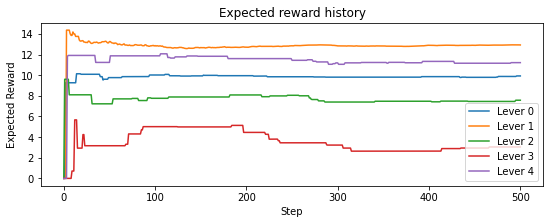

In [184]:
mab_agent_gaussian.plot_reward_history()

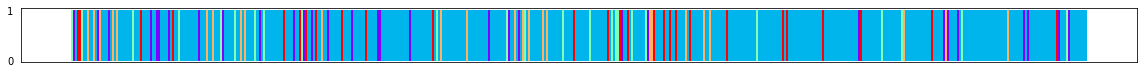

In [185]:
mab_agent_gaussian.plot_sequence()

### Bernoulli Reward

In [186]:
slot_machine_bernoulli = SlotMachine([0.45, 0.5, 0.1, 0.52], 'bernoulli', seed = SEED)
mab_agent_bernoulli = MAB(
    n_levers = slot_machine_bernoulli.n_levers, 
    epsilon=0.3, 
    estimation_policy='avg',
    seed = SEED)
mab_agent_bernoulli = run_mab(mab_agent_bernoulli, slot_machine_bernoulli, 500)

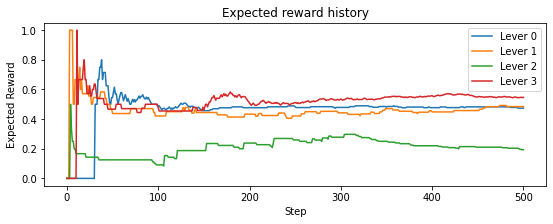

In [187]:
mab_agent_bernoulli.plot_reward_history()

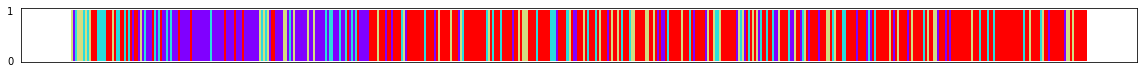

In [188]:
mab_agent_bernoulli.plot_sequence()